# Determination of the optimum risks porfolio using the Markowitz model
Before we begin let define some key concepts and terms.
## What is Markowitz model?
The Markowitz model is an investment technique. It is used to create a portfolio that would yield maximized returns.
It suggests that the risks can be minimized through diversification. Simultaneously, the model assures maximization of overall portfolio returns. 
The theory assist in the selection of the most efficient portfolio by considering various possible portfolios of the given securities based on expected returns(mean) and risk(Variance)
Investors are presented with two types of stocks—low-risk, low-return, and high-risk, high-return stocks.
The risk of the portfolio can be measured by the volatility that can be approximated by the standard deviation or the variance.
An eficient portfolio therefore, is that portfolio that has the highest reward for a given level of risk or the lowest risk for a given return. 

## Assumptions
(1) Returns are normally distributed
(2) Markowitz assumes that all investors are risk-averse(i.e investors will take on more risks if they are expecting more returns)

## Sharpe Ratio
The Sharpe ratio is a measure of risk-adjusted return. It describes how much excess return you receive for the volatility of holding a riskier asset.
The Sharpe ratio compares the return of an investment with its risk.

## Capital allocation line
The capital allocation line (CAL) shows you all possible portfolios that can be created by combining a risk-free asset with a risky portfolio in different proportions. CAL helps investors dettermine their risk tolerance through a mix of risky and risk freee assets based on their financial goals.

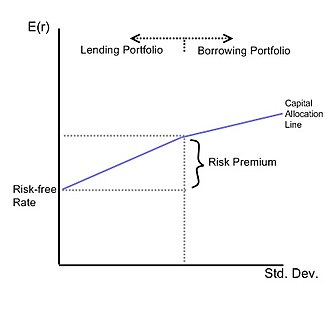


## Library Imports
The first thing we need to do is import the open-source software libraries that we'll be using for this project


In [1]:
import numpy as np
import yfinance as yf
import pandas as pd
import matplotlib.pyplot as plt
import scipy.optimize as optimization



Next is to determine the number of trading days and the stocks we will going to use and the historical data dates

In [3]:
# on average there are 252 trading days in a year
NUM_TRADING_DAYS = 252
# we will generate random w (different portfolios)
NUM_PORTFOLIOS = 10000


Stocks we are going to handle


In [5]:
stocks = ['AAPL', 'WMT', 'TSLA', 'GE', 'AMZN', 'DB']
# historical data - define START and END dates
start_date = '2010-01-01'
end_date = '2017-01-01'




We will need to create functions to download the data, show the data downloaded, calculate the returns, e.t.c We will be downloading our data from yahoo finance as imported earlier

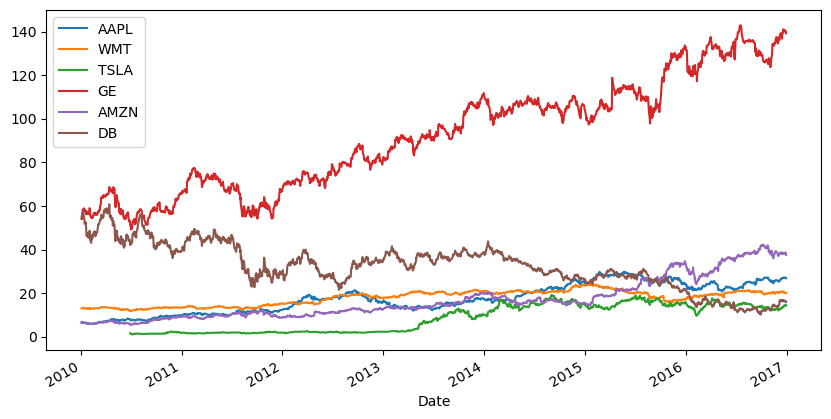

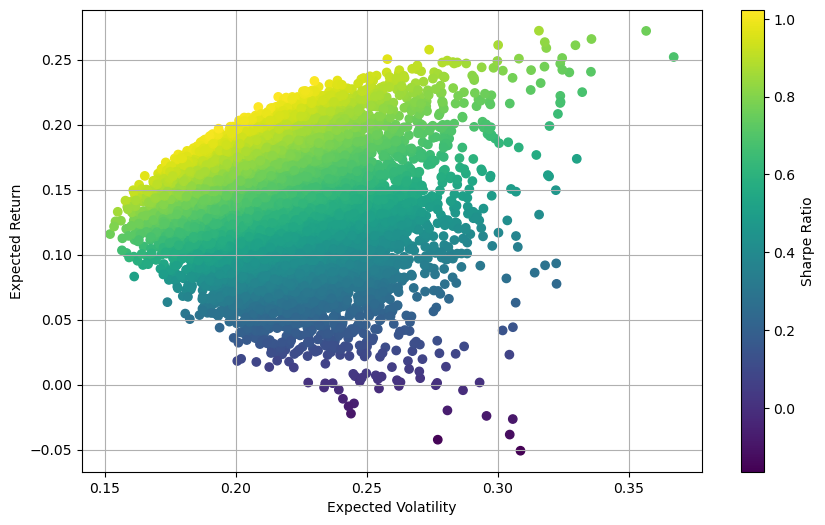

Optimal portfolio:  [0.363 0.076 0.141 0.155 0.264 0.   ]
Expected return, volatility and Sharpe ratio:  [0.21218696 0.20555029 1.03228734]


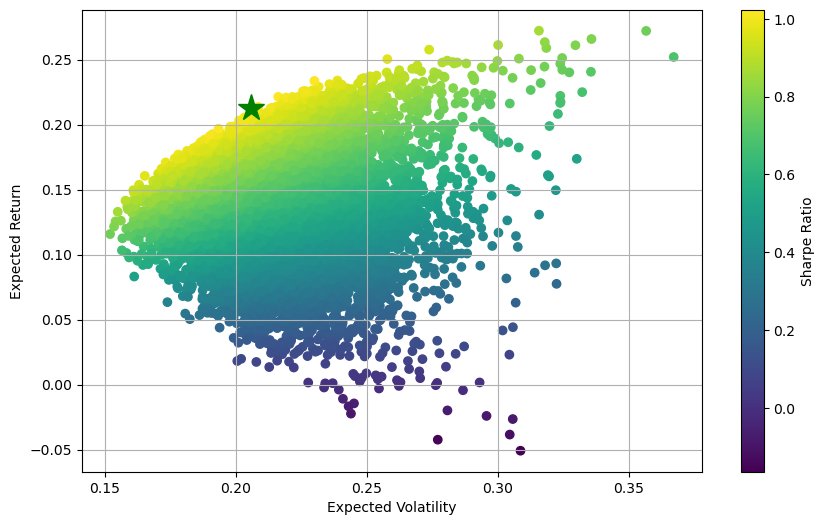

In [7]:
def download_data():
    # name of the stock (key) - stock values (2010-2017) as the values
    stock_data = {}
    # We will need to run a for loop to return only the closing prices 
    for stock in stocks:
        # closing prices
        ticker = yf.Ticker(stock)
        stock_data[stock] = ticker.history(start=start_date, end=end_date)['Close']

    return pd.DataFrame(stock_data)

def show_data(data):
    data.plot(figsize=(10, 5))
    plt.show()

def calculate_return(data):
    # NORMALIZATION - to measure all variables in comparable metric
    log_return = np.log(data / data.shift(1))
    return log_return[1:]
    
def show_statistics(returns):
    # instead of daily metrics we are after annual metrics
    # mean of annual return
    print(returns.mean() * NUM_TRADING_DAYS)
    print(returns.cov() * NUM_TRADING_DAYS)

def show_mean_variance(returns, weights):
    # we are after the annual return
    portfolio_return = np.sum(returns.mean() * weights) * NUM_TRADING_DAYS
    portfolio_volatility = np.sqrt(np.dot(weights.T, np.dot(returns.cov()
                                                            * NUM_TRADING_DAYS, weights)))
    print("Expected portfolio mean (return): ", portfolio_return)
    print("Expected portfolio volatility (standard deviation): ", portfolio_volatility)

def show_portfolios(returns, volatilities):
    plt.figure(figsize=(10, 6))
    plt.scatter(volatilities, returns, c=returns / volatilities, marker='o')
    plt.grid(True)
    plt.xlabel('Expected Volatility')
    plt.ylabel('Expected Return')
    plt.colorbar(label='Sharpe Ratio')
    plt.show()


def generate_portfolios(returns):
    portfolio_means = []
    portfolio_risks = []
    portfolio_weights = []

    for _ in range(NUM_PORTFOLIOS):
        w = np.random.random(len(stocks))
        w /= np.sum(w)
        portfolio_weights.append(w)
        portfolio_means.append(np.sum(returns.mean() * w) * NUM_TRADING_DAYS)
        portfolio_risks.append(np.sqrt(np.dot(w.T, np.dot(returns.cov()
                                                          * NUM_TRADING_DAYS, w))))

    return np.array(portfolio_weights), np.array(portfolio_means), np.array(portfolio_risks)

def statistics(weights, returns):
    portfolio_return = np.sum(returns.mean() * weights) * NUM_TRADING_DAYS
    portfolio_volatility = np.sqrt(np.dot(weights.T, np.dot(returns.cov()
                                                            * NUM_TRADING_DAYS, weights)))
    return np.array([portfolio_return, portfolio_volatility,
                     portfolio_return / portfolio_volatility])


# scipy optimize module can find the minimum of a given function
# the maximum of a f(x) is the minimum of -f(x)
def min_function_sharpe(weights, returns):
    return -statistics(weights, returns)[2]


# what are the constraints? The sum of weights = 1 !!!
# f(x)=0 this is the function to minimize
def optimize_portfolio(weights, returns):
    # the sum of weights is 1
    constraints = ({'type': 'eq', 'fun': lambda x: np.sum(x) - 1})
    # the weights can be 1 at most: 1 when 100% of money is invested into a single stock
    bounds = tuple((0, 1) for _ in range(len(stocks)))
    return optimization.minimize(fun=min_function_sharpe, x0=weights[0], args=returns
                                 , method='SLSQP', bounds=bounds, constraints=constraints)


def print_optimal_portfolio(optimum, returns):
    print("Optimal portfolio: ", optimum['x'].round(3))
    print("Expected return, volatility and Sharpe ratio: ",
          statistics(optimum['x'].round(3), returns))


def show_optimal_portfolio(opt, rets, portfolio_rets, portfolio_vols):
    plt.figure(figsize=(10, 6))
    plt.scatter(portfolio_vols, portfolio_rets, c=portfolio_rets / portfolio_vols, marker='o')
    plt.grid(True)
    plt.xlabel('Expected Volatility')
    plt.ylabel('Expected Return')
    plt.colorbar(label='Sharpe Ratio')
    plt.plot(statistics(opt['x'], rets)[1], statistics(opt['x'], rets)[0], 'g*', markersize=20.0)
    plt.show()

#Creating the main function

if __name__ == '__main__':
    dataset = download_data()
    show_data(dataset)
    log_daily_returns = calculate_return(dataset)
    # show_statistics(log_daily_returns)

    pweights, means, risks = generate_portfolios(log_daily_returns)
    show_portfolios(means, risks)
    optimum = optimize_portfolio(pweights, log_daily_returns)
    print_optimal_portfolio(optimum, log_daily_returns)
    show_optimal_portfolio(optimum, log_daily_returns, means, risks)





#### In conclusion, the optimum portfolio that will generate the best returns will be to invests 36% of our capital in Apple, 7% in Walmart, 14% in Tesla,15% in General Electric and 26% in Amazon.